In [1]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


In [2]:
start_date = datetime.datetime(2000, 10, 1)
end_date = datetime.datetime(2019, 10, 1)
aapl = pdr.get_data_yahoo('AAPL', start=start_date, end=end_date)

In [3]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-10-02,1.910714,1.678571,1.906250,1.732143,606197200.0,1.511664
2000-10-03,1.785714,1.584821,1.781250,1.593750,509530000.0,1.390887
2000-10-04,1.696429,1.562500,1.598214,1.687500,366506000.0,1.472704
2000-10-05,1.750000,1.571429,1.678571,1.575893,218251600.0,1.375302
2000-10-06,1.638393,1.500000,1.620536,1.584821,153164200.0,1.383095


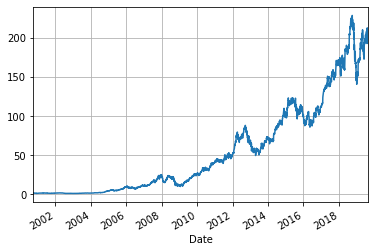

In [4]:
aapl['Adj Close'].plot(grid = True) # Plot the adjusted closing price of AAPL


In [5]:
# Short moving window rolling mean
aapl['fast'] = aapl['Adj Close'].rolling(window=5).mean()
# Short moving window rolling mean
aapl['slow'] = aapl['Adj Close'].rolling(window=10).mean()


In [6]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

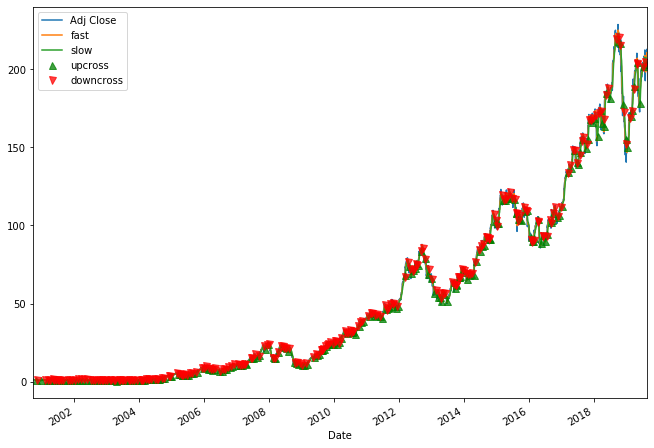

In [7]:
up = get_up_cross(aapl)
down = get_down_cross(aapl)

f, ax = plt.subplots(figsize=(11,8))

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', 'fast', 'slow']].plot(ax=ax, grid=True)

up.plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [8]:
display(len(up.index), len(down.index))

243

242

In [9]:
# Creates a labebls
side_up = pd.Series(1, index=up.index).dropna()
side_down = pd.Series(-1, index=down.index).dropna()
side = pd.concat([side_up,side_down]).sort_index()
display(side[:5], side.shape)

Date
2000-11-01    1
2000-11-10   -1
2000-12-27    1
2001-02-07   -1
2001-03-02    1
dtype: int64

(485,)

In [10]:
crossEvents = side.index
crossEvents[:5]

DatetimeIndex(['2000-11-01', '2000-11-10', '2000-12-27', '2001-02-07',
               '2001-03-02'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [11]:
adj_close = aapl['Adj Close']
adj_close[:5]

Date
2000-10-02    1.511664
2000-10-03    1.390887
2000-10-04    1.472704
2000-10-05    1.375302
2000-10-06    1.383095
Name: Adj Close, dtype: float64

In [12]:
def metaLabling(close, startEvents, side, verticalBarrier = None, SL = None, TP = None):
    if verticalBarrier is None:
        verticalBarrier = pd.Series(close.index[-1], index=startEvents)
        
    if TP is None:
        TP = 10.0

    if SL is None:
        SL = 10.0

    ret = pd.DataFrame(columns=['touch_tp', 'raw_return', 'p_return', 'side'], index=startEvents)
    t_touch = 0
    r_ret = 0
    p_ret = 0
    
    for t0 in tqdm(startEvents):
   # for t0 in startEvents:
        window=close[t0:verticalBarrier[t0]]
        
        if(side[t0] == 1):
            trgHi = close[t0] * TP
            trgLow = close[t0] * SL
        else:
            trgHi = close[t0] * SL
            trgLow = close[t0] * TP
        
        fabove = window >= (trgHi+close[t0])
        fbelow = window <= (close[t0]-trgLow)
        
        hiTouch = window[fabove].index.min()
        lowTouch = window[fbelow].index.min()
        
        #print('ht',(hiTouch))
        #print('lt',(lowTouch))
        
        if ((pd.isnull(hiTouch)) and (pd.isnull(lowTouch))):
            #display('vertical barrier or infinit')
            t_touch = 0
            r_ret = close[verticalBarrier[t0]]
            
        elif (pd.isnull(hiTouch) and (not pd.isnull(lowTouch))):
            #display('low touch')
            t_touch = -1 
            r_ret = close[lowTouch]
        elif (not pd.isnull(hiTouch) and (pd.isnull(lowTouch))):
            #display('hi touch')
            t_touch = 1 
            r_ret = close[hiTouch]
        elif(hiTouch < lowTouch):
            #display('HI')
            t_touch = 1
            r_ret = close[hiTouch]
        else:
           # display('LOW')
            t_touch = -1
            r_ret = close[lowTouch]

            
        ret.loc[t0].touch_tp = t_touch * side[t0]
        ret.loc[t0].raw_return = abs(r_ret - close[t0]) * ret.loc[t0].touch_tp
        ret.loc[t0].p_return = abs(r_ret / close[t0] - 1 ) * ret.loc[t0].touch_tp
        ret.loc[t0].side = side[t0]

        
    return ret
    

In [13]:
df_met = metaLabling(adj_close, crossEvents, side, None, 0.010, 0.015)
df_met.head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:06<00:00, 74.22it/s]


,touch_tp,raw_return,p_return,side
Date,,,,
2000-11-01,1,0.112985,0.0884147,1
2000-11-10,-1,-0.0194805,-0.0163937,-1
2000-12-27,1,0.0974008,0.105485,1
2001-02-07,1,0.101297,0.078313,-1
2001-03-02,1,0.0701286,0.0584414,1
2001-03-14,1,0.0467522,0.036697,-1
2001-03-21,1,0.0935049,0.0745341,1
2001-04-03,1,0.0461287,0.036561,-1
2001-04-12,-1,-0.0610901,-0.0437111,1


In [14]:
aapl_f = pd.merge(aapl, df_met, left_index=True, right_index=True)
aapl_f.head()

,High,Low,Open,Close,Volume,Adj Close,fast,slow,touch_tp,raw_return,p_return,side
Date,,,,,,,,,,,,
2000-11-01,1.491071,1.388393,1.388393,1.464286,143841600.0,1.277901,1.202318,1.200760,1,0.112985,0.0884147,1
2000-11-10,1.419643,1.361607,1.382812,1.361607,105562800.0,1.188292,1.272447,1.284135,-1,-0.0194805,-0.0163937,-1
2000-12-27,1.058036,1.013393,1.024554,1.058036,81366600.0,0.923362,0.909336,0.901934,1,0.0974008,0.105485,1
2001-02-07,1.491071,1.415179,1.475446,1.482143,98471800.0,1.293485,1.294265,1.298940,1,0.101297,0.078313,-1
2001-03-02,1.459821,1.303571,1.308036,1.375000,101550400.0,1.199981,1.185955,1.177773,1,0.0701286,0.0584414,1


In [15]:
display("before:", aapl_f.touch_tp.value_counts())
f = aapl_f.raw_return < 0.10
aapl_f.loc[f,'touch_tp'] = 0
f = aapl_f.touch_tp == -1
aapl_f.loc[f,'touch_tp'] = 0
aapl_f[f].head()
display("after:", aapl_f.touch_tp.value_counts())

'before:'

-1    254
 1    231
Name: touch_tp, dtype: int64

'after:'

0    307
1    178
Name: touch_tp, dtype: int64

In [16]:
X = aapl_f[['Volume', 'Adj Close', 'fast', 'slow', 'side']]
y = aapl_f.touch_tp
X.shape

(485, 5)